In [1]:
#import the libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('tweet_train.csv')
df_india = pd.read_csv('tweet_test.csv')

In [3]:
#Create a function to clean the tweets
def cleanTxt(text):
    text = text.lower()
    #remove @,#,hyperlinks
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)
    text = re.sub(r'@[A-Za-z0-9]+|#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]+', '', text) 
    #remove stop words
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

#Cleaning the text
df['Tweets'] = df['Tweets'].apply(cleanTxt) 

df = df.drop_duplicates(subset=['Tweets', 'Sentiment'], keep=False)

#Show cleaned text
print(df)

                                                 Tweets Sentiment
0     ban mineral water companies ( three near ) abs...  Positive
1     ange wanting risk players joke pitch tomorrow ...  Positive
2     rwanda africa bans plastic bags . ban beer col...  Positive
3     strict ban single use plastic bags must implem...  Negative
4     get ban supermarkets making infinitely shit pl...  Negative
...                                                 ...       ...
3707  humans suck '' striking photos reveal impact s...  Positive
3708  would like invite influencers world leaders jo...   Neutral
3709  proposed project : data visualization dissects...   Neutral
3710     cyprus beaches high risk plastic pollution [ ]  Positive
3711  got plot early morning huge roll bubble wrap t...  Negative

[2803 rows x 2 columns]


In [4]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

df['Tweets'] = df['Tweets'].apply(lambda x: stemming(x))
df

,Tweets,Sentiment
0,ban mineral water companies ( three near ) abs...,Positive
1,ange wanting risk players joke pitch tomorrow ...,Positive
2,rwanda africa bans plastic bags . ban beer col...,Positive
3,strict ban single use plastic bags must implem...,Negative
4,get ban supermarkets making infinitely shit pl...,Negative
...,...,...
3707,humans suck '' striking photos reveal impact s...,Positive
3708,would like invite influencers world leaders jo...,Neutral
3709,proposed project : data visualization dissects...,Neutral
3710,cyprus beaches high risk plastic pollution [ ],Positive


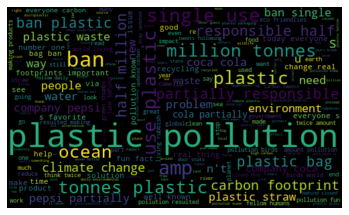

In [5]:
#How well the sentiments are distributed
#using wordcloud - a visualization where a word appears
#Plot word cloud
allWords = ' '.join([twts for twts in df['Tweets']])
wordCloud = WordCloud(width=500,height=300,random_state=21,max_font_size=119).generate(allWords)

plt.imshow(wordCloud,interpolation="bilinear")
plt.axis('off')
plt.show()

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

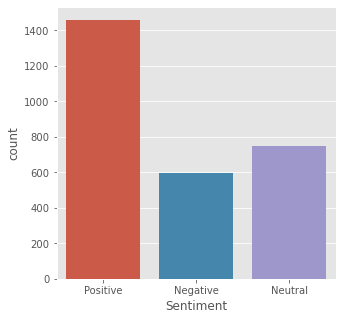

In [6]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='Sentiment', data = df)

Text(0.5, 1.0, 'Distribution of sentiments')

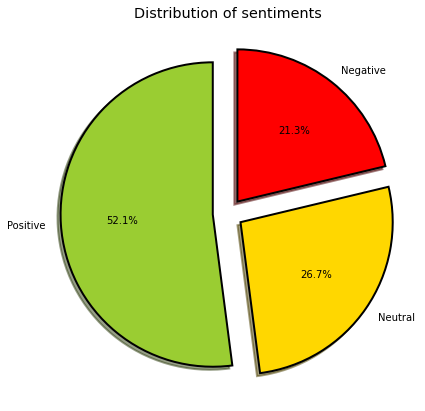

In [7]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = df['Sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [8]:
#Print all of the positive tweets
pos_tweets = df[df.Sentiment == 'Positive']
pos_tweets.head()

,Tweets,Sentiment
0,ban mineral water companies ( three near ) abs...,Positive
1,ange wanting risk players joke pitch tomorrow ...,Positive
2,rwanda africa bans plastic bags . ban beer col...,Positive
5,scotland 's single-use plastic ban exempt uk i...,Positive
6,excited see partnership featured ! 're helping...,Positive


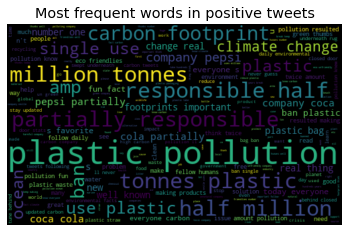

In [9]:
#How well the sentiments are distributed
#using wordcloud - a visualization where a word appears
#Plot word cloud
allWords = ' '.join([twts for twts in pos_tweets['Tweets']])
wordCloud = WordCloud(width=500,height=300,random_state=21,max_font_size=119).generate(allWords)

plt.imshow(wordCloud,interpolation="bilinear")
plt.axis('off')
plt.title('Most frequent words in positive tweets')
plt.show()

In [10]:
neg_tweets = df[df.Sentiment == 'Negative']
neg_tweets.head()

,Tweets,Sentiment
3,strict ban single use plastic bags must implem...,Negative
4,get ban supermarkets making infinitely shit pl...,Negative
9,culver citys former mayor councilwoman meghan ...,Negative
14,look man-it 's put plastic coat top dogs fur c...,Negative
16,ban single use plastic bottled water bottles c...,Negative


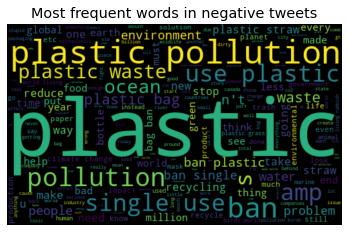

In [11]:
#How well the sentiments are distributed
#using wordcloud - a visualization where a word appears
#Plot word cloud
allWords = ' '.join([twts for twts in neg_tweets['Tweets']])
wordCloud = WordCloud(width=500,height=300,random_state=21,max_font_size=119).generate(allWords)

plt.imshow(wordCloud,interpolation="bilinear")
plt.axis('off')
plt.title('Most frequent words in negative tweets')
plt.show()

In [12]:
def get_ngrams(text, ngram_from=1, ngram_to=2, n=None, max_features=20000):
    
    vec = CountVectorizer(ngram_range = (ngram_from, ngram_to), 
                          max_features = max_features, 
                          stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    
    return bag_of_words

In [13]:
X = get_ngrams(df['Tweets'], ngram_from=1, ngram_to=2, max_features=5000)
Y = df['Sentiment']

In [14]:
models={
    "Decision Tree":DecisionTreeClassifier(),
    "Random Forest":RandomForestClassifier(),
    "Gradient Boost":GradientBoostingClassifier(),
    "Support Vector Machine":SVC(kernel="linear",C=1)
}

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test:", (x_test.shape))
print("Size of y_test:", (y_test.shape))

Size of x_train: (2242, 5000)
Size of y_train: (2242,)
Size of x_test: (561, 5000)
Size of y_test: (561,)


In [16]:
import warnings
warnings.filterwarnings('ignore')

Model performance for Test set
Decision Tree
>> Accuracy: 0.6275
>> F1 score: 0.6268
>> Precision: 0.6301
>> Recall: 0.6275
              precision    recall  f1-score   support

    Negative       0.42      0.39      0.40       108
     Neutral       0.60      0.70      0.65       166
    Positive       0.73      0.67      0.70       287

    accuracy                           0.63       561
   macro avg       0.58      0.59      0.58       561
weighted avg       0.63      0.63      0.63       561

****************************************
Random Forest
>> Accuracy: 0.6720
>> F1 score: 0.6623
>> Precision: 0.6907
>> Recall: 0.6720
              precision    recall  f1-score   support

    Negative       0.69      0.33      0.45       108
     Neutral       0.56      0.81      0.67       166
    Positive       0.76      0.72      0.74       287

    accuracy                           0.67       561
   macro avg       0.67      0.62      0.62       561
weighted avg       0.69      0.67  

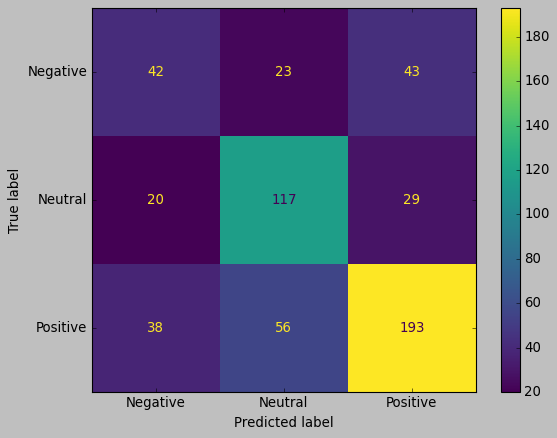

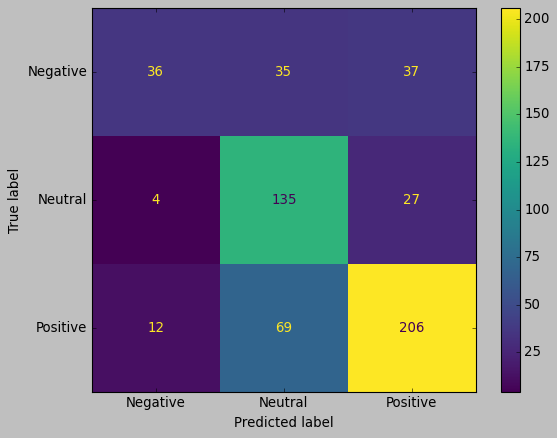

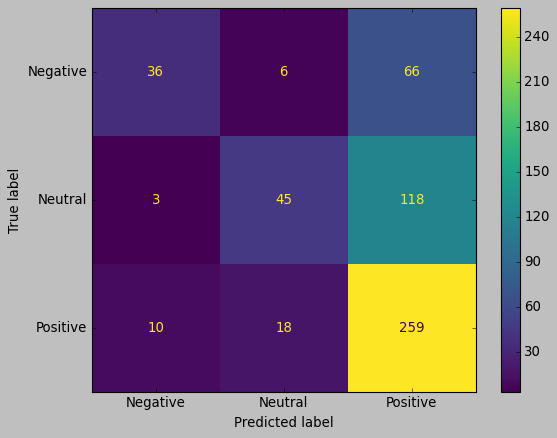

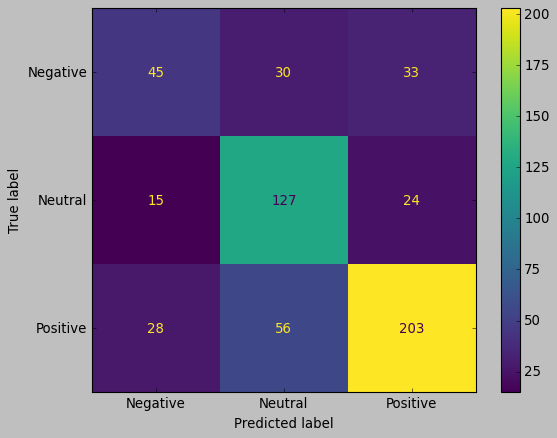

In [17]:
print('Model performance for Test set')
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(x_train, y_train)
    
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    #Test set performance
    model_test_accuracy = accuracy_score(y_test,y_test_pred)
    model_test_f1 = f1_score(y_test,y_test_pred, average="weighted")
    model_test_precision = precision_score(y_test,y_test_pred, average="weighted")
    model_test_recall = recall_score(y_test,y_test_pred, average="weighted")
    
    print(list(models.keys())[i])
    
    print(">> Accuracy: {:.4f}".format(model_test_accuracy))
    print(">> F1 score: {:.4f}".format(model_test_f1))
    print(">> Precision: {:.4f}".format(model_test_precision))
    print(">> Recall: {:.4f}".format(model_test_recall))
    
    print(classification_report(y_test,y_test_pred))
    
    style.use('classic')
    cm = confusion_matrix(y_test, y_test_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=model.classes_)
    disp.plot()
    
    print('*'*40)

In [18]:
print('Model performance')
#Accuracy Score
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(x_train, y_train)
    
    cross_validation = cross_val_score(model,X,Y,cv=10,scoring='accuracy').mean()
    
    print(list(models.keys())[i],"{:.4f}".format(cross_validation))
    

Model performance
Decision Tree 0.6055
Random Forest 0.6458
Gradient Boost 0.6297
Support Vector Machine 0.6472


In [19]:
# Selecting parameters with Hyper Parameter Optimization
svm_linear = {'C': [0.1, 1, 10, 100, 1000], 
              'kernel': ['linear']} 
svm_others = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001,'auto'], 
              'kernel': ['poly', 'rbf', 'sigmoid']}
model=SVC()
parameters = [svm_linear, svm_others]
cval=KFold(n_splits=5)
grid = GridSearchCV(model, param_grid=parameters, cv=cval)
grid.fit(x_train, y_train)
print("Best parameters:", grid.best_params_)

Best parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


In [23]:
df_india['Tweets'] = df_india['Tweets'].apply(cleanTxt)
df_india = df_india.drop_duplicates(subset=['Tweets'], keep=False)
df_india['Tweets'] = df_india['Tweets'].apply(lambda x: stemming(x))

In [24]:
x1_test = get_ngrams(df_india['Tweets'], ngram_from=1, ngram_to=2, max_features=5000)

In [25]:
y_pred = grid.predict(x1_test)
df_india['predictions'] = y_pred
# df_india.to_csv('tweet_test.csv')
df_india.head()

,Tweets,predictions
0,nice sir ... plastic tiranga using people tota...,Positive
1,government ki 'single use plastic ' ban ki hyp...,Positive
2,need ban plastic flag sellers market‼️,Positive
3,agreed also ban plastic knives come cake neith...,Positive
4,_visakha _india _mohua _india support vizag si...,Positive


<AxesSubplot:xlabel='predictions', ylabel='count'>

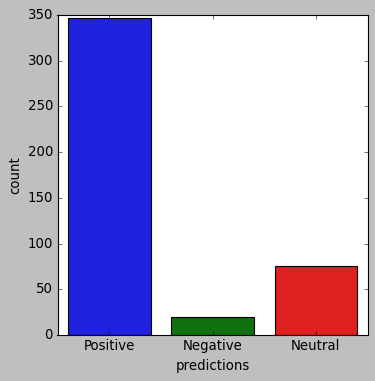

In [26]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='predictions', data = df_india)

Text(0.5, 1.0, 'Distribution of sentiments')

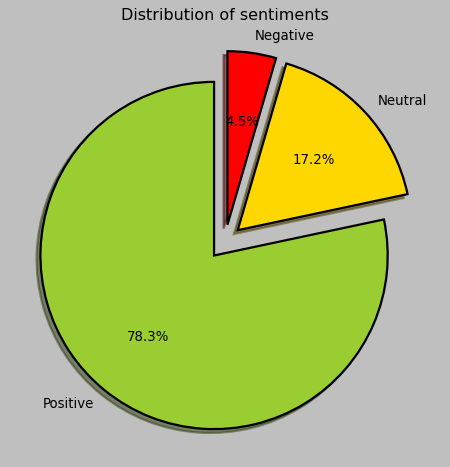

In [27]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = df_india['predictions'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')